In [116]:
#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf

In [117]:
# Load the test.csv file
test = pd.read_csv('train.csv')
print(test.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

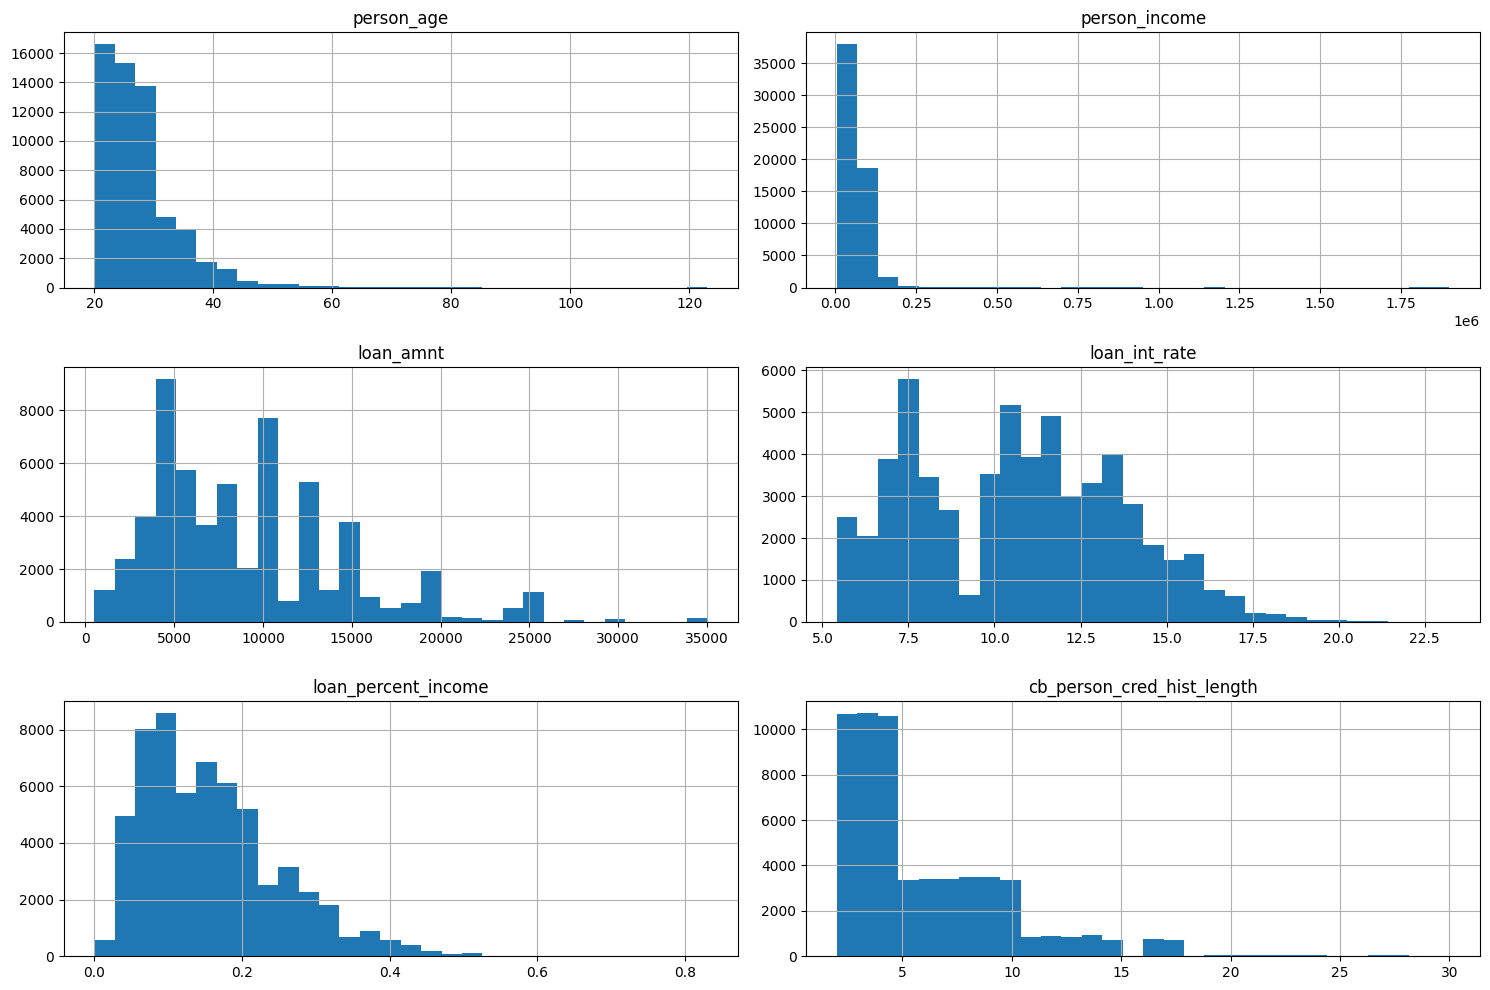

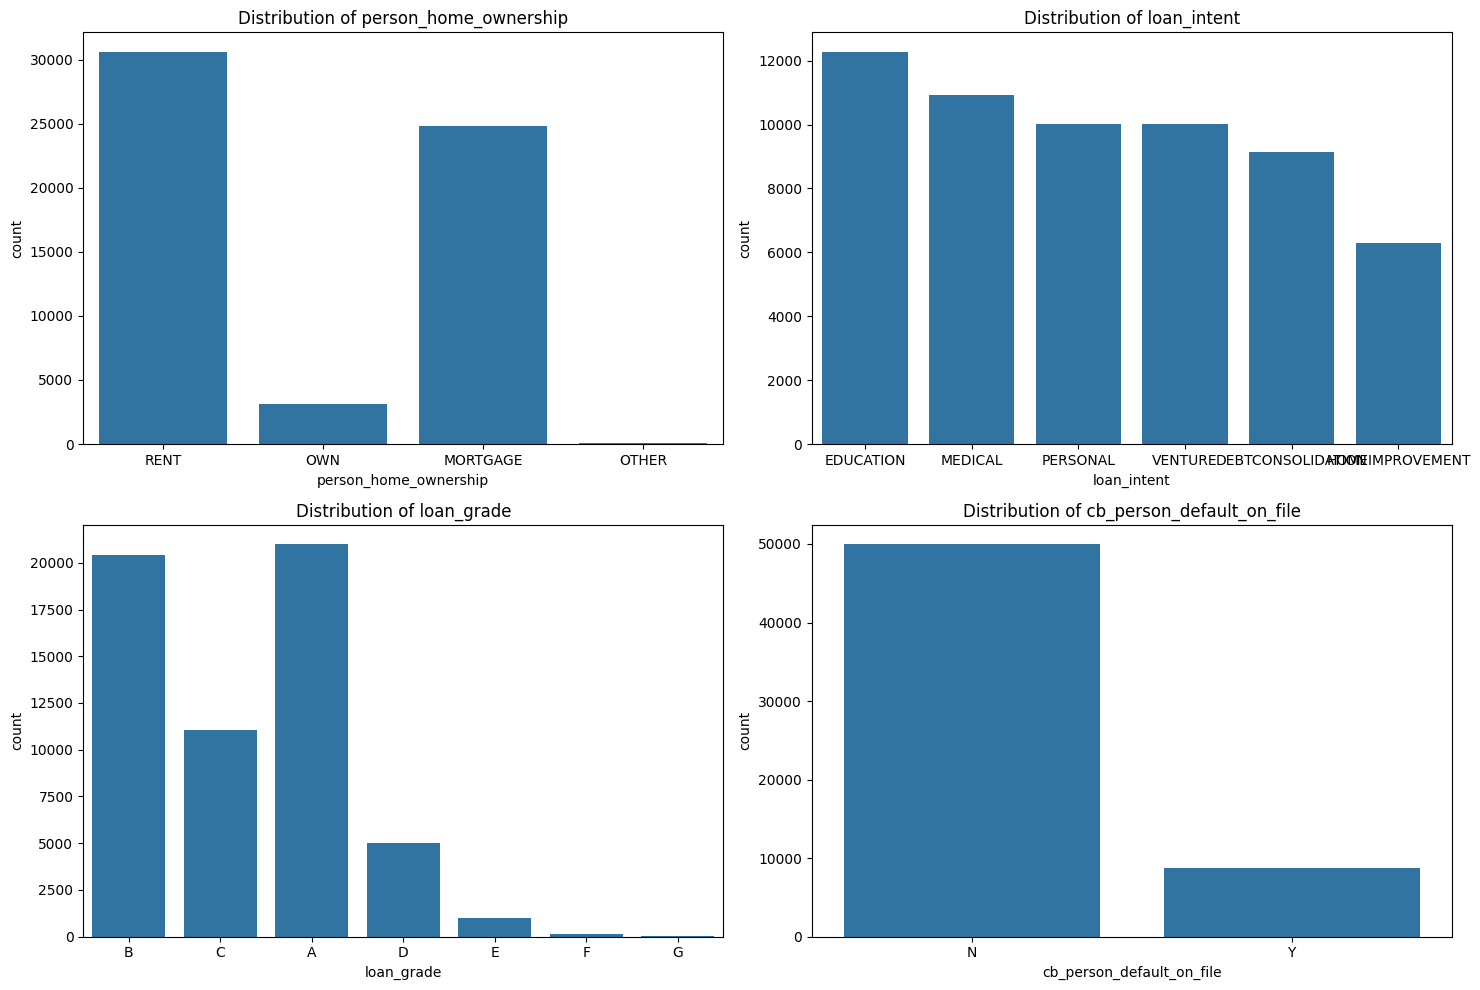

In [118]:
# Plot histograms for numerical columns
numerical_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
test[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=test, x=col, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [119]:
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score, roc_curve

# # Define the features and target
# features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
# target = 'loan_status'  # Replace with the actual target column name

# # Preprocess the data
# X = test[features]
# y = test[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Define the preprocessing for numerical and categorical features
# numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
# categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# # Preprocess the data
# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

# # Initialize the base layer size
# base_layer_size = 512  # Start with a larger base size

# # Loop to add layers and evaluate the model
# for i in range(1, 6):  # Adjust the range as needed
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    
#     # Add layers with sizes halving each iteration
#     for j in range(i):
#         model.add(tf.keras.layers.Dense(base_layer_size // (2 ** j), activation='relu'))
    
#     # Add the final output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     # Print the model summary
#     print(f'Iteration {i} Model Summary:')
#     model.summary()
    
#     # Train the model
#     history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    
#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
#     # Predict probabilities for the test set
#     y_pred_prob = model.predict(X_test)
    
#     # Apply threshold of 0.5 to get binary predictions
#     y_pred = (y_pred_prob > 0.5).astype(int)
#     # Assuming X_train and y_train are pandas DataFrames or Series
#     print("First 3 elements of X_train:")
#     print(pd.DataFrame(X_train).head(3))
    
#     print("\nFirst 3 elements of y_train:")
#     print(pd.Series(y_train).head(3))
    
#     # Assuming y_pred_prob and y_pred are numpy arrays
#     print("\nFirst 3 elements of y_pred_prob:")
#     print(pd.DataFrame(y_pred_prob).head(3))
    
#     print("\nFirst 3 elements of y_pred:")
#     print(pd.Series(y_pred.flatten()).head(3))    
#     # Calculate the ROC AUC score
#     roc_auc = roc_auc_score(y_test, y_pred)
    
#     # Print the metrics
#     print(f'Iteration {i}:')
#     print(f'  Layers: {[base_layer_size // (2 ** j) for j in range(i)]}')
#     print(f'  Loss: {loss}')
#     print(f'  Accuracy: {accuracy}')
#     print(f'  ROC AUC: {roc_auc}')
    
#     # Plot the ROC curve
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve - Iteration {i}')
#     plt.legend(loc='lower right')
#     plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd

# Define the features and target
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
target = 'loan_status'  # Replace with the actual target column name

# Preprocess the data
X = test[features]
y = test[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the preprocessing for numerical and categorical features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Hardcoded array
array = [11, 22, 33 ]

# Generate the power set of the array
power_set = list(itertools.chain.from_iterable(itertools.combinations(array, r) for r in range(1, len(array) + 1)))

# Loop to add layers and evaluate the model
for i, subset in enumerate(power_set, 1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    # Add layers with sizes from the subset
    for units in subset:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    # Add the final output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Print the model summary
    print(f'Iteration {i} Model Summary:')
    model.summary()
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Predict probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Apply threshold of 0.5 to get binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Print first 3 elements of X_train, y_train, y_pred_prob, y_pred
    # print("First 3 elements of X_train:")
    # print(pd.DataFrame(X_train).head(3))

    # print("\nFirst 3 elements of y_train:")
    # print(pd.Series(y_train).head(3))

    # print("\nFirst 3 elements of y_pred_prob:")
    # print(pd.DataFrame(y_pred_prob).head(3))

    # print("\nFirst 3 elements of y_pred:")
    # print(pd.Series(y_pred.flatten()).head(3))
    
    # Calculate the ROC AUC score using y_pred
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print the metrics
    # print(f'Iteration {i}:')
    # print(f'  Layers: {list(subset)}')
    print(f'  Loss: {loss}')
    print(f'  Accuracy: {accuracy}')
    print(f'  ROC AUC: {roc_auc}')
    
    # Plot the ROC curve using y_pred
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # plt.figure()
    # plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve - Iteration {i}')
    # plt.legend(loc='lower right')
    # plt.show()

Iteration 1 Model Summary:


C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_250 (Dense)               │ (None, 11)             │           297 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309 (1.21 KB)

 Trainable params: 309 (1.21 KB)

 Non-trainable params: 0 (0.00 B)

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


      id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                         

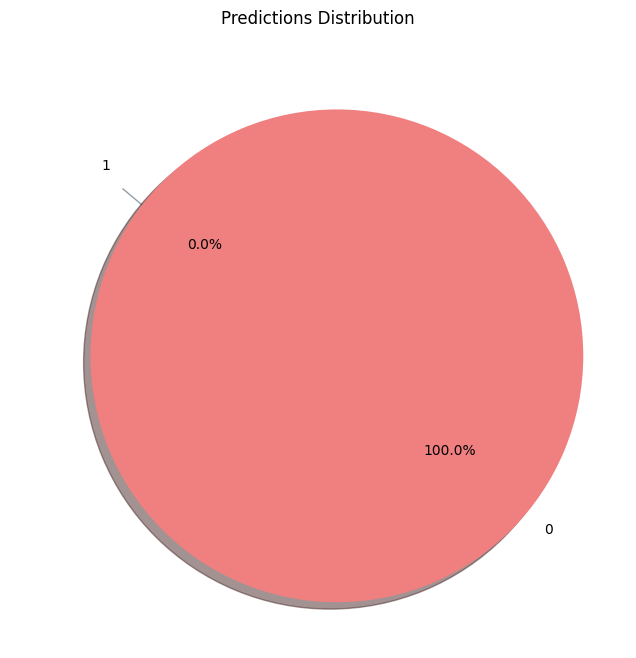

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Preprocess the data
X = test[features]
X = preprocessor.transform(X)

# Predict the values using the model
y_pred_prob = model.predict(X)

# Clip the predictions to 0 or 1 based on the threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()